In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(ggsci)
library(ggpubr)
library(ggtext)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Load data

In [2]:
res_dir <- "../results/trex.logit_ASALL_v2"

##  Visualize supplementary results

In [5]:
events_used<-c("AF","AL")
ev.colors<-pal_locuszoom()(7)[6:7]
names(ev.colors)<-events_used

In [6]:
res.stats<-readRDS("figures_v3_objects/tcga.condition.res.lfcShrink.stats.RDS") %>%
            filter(event_type%in%events_used)

In [7]:
totals<-res.stats %>%
        filter(analysis=="condition",exp_var=="conditiontumor") %>%
        group_by(cancer,event_type) %>%
        summarize(n=sum(total_events),.groups="drop") %>%
        select(-cancer) %>% group_by(event_type) %>% slice_max(n,n=1) %>%
        distinct(event_type,n) %>%
        arrange(desc(n))
totals

event_type,n
<chr>,<int>
AF,88366
SE,43947
AL,25740
A3,18331
A5,16465
RI,7892
MX,6187


In [8]:
res.stats<-res.stats%>%
           mutate(event_type=factor(event_type,levels=totals$event_type)) %>%
           mutate(exp_var=case_when(exp_var=="conditiontumor" ~ "tumor",
                                    exp_var=="sex1" ~ "sex",
                                   TRUE ~ exp_var)) %>%
           mutate(exp_var=factor(exp_var,levels = c("tumor","impurity","sex","age")))%>%
           mutate(cancer=factor(cancer,levels=c("SKCM","SARC","UCEC","CESC","PRAD",
                                                "READ","BLCA","COAD","PAAD","CHOL",
                                                "KIRP","KIRC","KICH","PCPG","STAD",
                                                "LIHC","LUSC","LUAD","BRCA","THCA",
                                                "ESCA","HNSC"))) %>% 
          mutate(log_sig_events=ifelse(direction=="up",log10(sig_events),-1*log10(abs(sig_events))))%>%
          mutate(log_sig_events=ifelse(sig_events==0,0,log_sig_events))%>%
          mutate(p_sig_events = (sig_events/total_events)) %>%
          mutate(log_p_sig_events=ifelse(direction=="up",log10(p_sig_events),-1*log10(abs(p_sig_events))))%>%
          mutate(log_p_sig_events=ifelse(sig_events==0,0,log_sig_events))

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


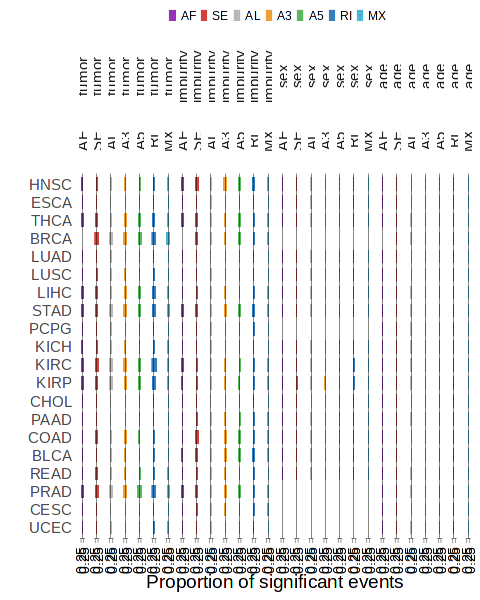

In [9]:
options(repr.plot.width=4,repr.plot.height=5)
p<-ggplot(res.stats,aes(x=cancer,y=p_sig_events,fill=event_type))+
    geom_bar(stat="identity",width=0.7) +
    coord_flip()+
    facet_grid(~exp_var+event_type)+
    geom_hline(yintercept = 0,linewidth=0.1)+
    theme(legend.position = "top",
          panel.background = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.ticks.y = element_blank(),
          axis.ticks.x = element_line(size=0.1),
          axis.text.x = element_text(angle=90,vjust=0.5,hjust = 0.5,size=8,color="black"),
          axis.line.x = element_line(colour = 'black', size=0.1, linetype='solid'),
          legend.key.height= unit(0.25, 'cm'),
          legend.key.width= unit(0.15, 'cm'),
          legend.spacing.x = unit(0.1, 'cm'),
          legend.margin=margin(t = 0, unit='cm'),
          legend.text = element_text(size=7),
          strip.background = element_blank(),
          strip.text = element_text(angle=90),
          panel.spacing.y = unit(0.1, "cm"))+
    labs(x="",y="Proportion of significant events",fill="")+
    guides(fill=guide_legend(ncol=7))+
    scale_fill_manual(values = ev.colors )+
    scale_y_continuous(breaks = c(-0.25,0.25),minor_breaks = c(-0.1,0.1),labels = c("0.25","0.25"))
p

In [ ]:
legend<-get_legend(p)%>%as_ggplot(.)
ggsave(plot=legend,filename = "figures_v3/event_summaries_sup/legend.barcodes.all.events.condition.lfcShrink.pdf",width = 4,height=0.5,units="in",device="pdf")
p<-p+theme(legend.position="none")
ggsave(plot=p,filename="figures_v3/event_summaries_sup/barcodes.all.events.condition.lfcShrink.pdf",width = 4,height=5,units="in",device = "pdf")

# Extra

In [ ]:
data <- totals %>% 
  arrange(desc(event_type)) %>%
  mutate(prop = n / sum(totals$n) *100) %>%
  mutate(ypos = cumsum(prop)- 0.5*prop,
        lab = paste0(n),
        event_type=factor(event_type,levels = totals$event_type))

p<-data %>%
    ggplot(.,aes(x=1,y=prop,fill=event_type))+
      geom_bar(stat="identity", width=1, color="white") +
      coord_polar("y", start=0,) +
      scale_fill_manual(values=ev.colors)+
      theme_void()+
      theme(axis.text.x = element_text(color="black",vjust = 20,face="bold"),
            legend.position="none")+
      scale_y_continuous(breaks=cumsum(data$prop) - data$prop / 2, labels = data$lab)
p

In [ ]:
ggsave(plot=p,filename="figures_v3/event_summaries_sup/piechart.all.events.condition.lfcShrink.pdf",width = 2.5,height=2.5,units="in",device = "pdf")